<a href="https://colab.research.google.com/github/raunaqjabbal/NeuralStyleTransfer/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
from tensorflow.keras.utils import load_img, img_to_array
from PIL import Image
import time

import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_img(path_to_img):
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  new_shape = tf.cast(tf.shape(image)[:-1] * max_dim / max(tf.shape(image)) , tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)
  
  return image
    
def show_images_with_objects(images, titles=[]):
  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.squeeze(image))
    if title:
      plt.title(title)


def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  return x_var, y_var

def plot_deltas_for_single_image(x_deltas, y_deltas, name, row=1):
  plt.figure(figsize=(14,20))
  plt.subplot(row,2,1),plt.yticks([]),plt.xticks([])
  clipped_y_deltas = tf.clip_by_value(y_deltas ,0 ,1)
  plt.imshow(clipped_y_deltas[0])
  plt.title("Horizontal Deltas: {}".format(name))
  
  plt.subplot(row,2,2),plt.yticks([]),plt.xticks([])
  clipped_x_deltas = tf.clip_by_value(x_deltas ,0 ,1)
  plt.imshow(clipped_x_deltas[0])
  plt.title("Vertical Deltas: {}".format(name))


def plot_deltas(original_image_deltas, stylized_image_deltas,loc):
  orig_x_deltas, orig_y_deltas = original_image_deltas
  stylized_x_deltas, stylized_y_deltas = stylized_image_deltas
  
  plt.figure(figsize=(12,20))
  plt.subplot(1,2,1),plt.yticks([]),plt.xticks([])
  clipped_y_deltas = tf.clip_by_value(orig_y_deltas ,0 ,1)
  plt.imshow(clipped_y_deltas[0])
  plt.title("Horizontal Deltas: Original Image ")
  plt.subplot(1,2,2),plt.yticks([]),plt.xticks([])
  clipped_x_deltas = tf.clip_by_value(orig_x_deltas ,0 ,1)
  plt.imshow(clipped_x_deltas[0])
  plt.title("Vertical Deltas: Original Image ")
  plt.savefig(PATH+prefix+" "+loc+" Original.jpg", bbox_inches='tight')


  plt.figure(figsize=(12,20))
  plt.subplot(1,2,1),plt.yticks([]),plt.xticks([])
  clipped_y_deltas = tf.clip_by_value(stylized_y_deltas ,0 ,1)
  plt.imshow(clipped_y_deltas[0])
  plt.title("Horizontal Deltas: Stylized Image "+loc)
  plt.subplot(1,2,2),plt.yticks([]),plt.xticks([])
  clipped_x_deltas = tf.clip_by_value(stylized_x_deltas ,0 ,1)
  plt.imshow(clipped_x_deltas[0])
  plt.title("Vertical Deltas: Stylized Image "+loc)
  plt.savefig(PATH+prefix+" "+loc+" Generated.jpg", bbox_inches='tight')


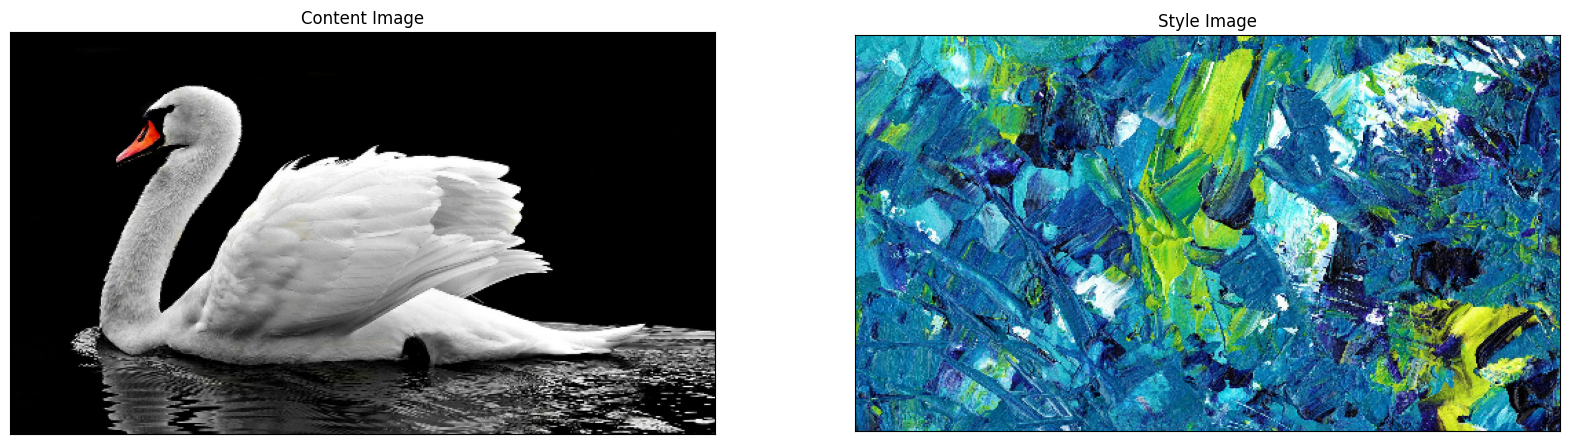

In [ ]:
prefix='(2)'
PATH='drive/MyDrive/CV Project/'
content_image = load_img(PATH+prefix+' Content.jpg')
style_image = load_img(PATH+prefix+' Style.jpg')
show_images_with_objects([content_image, style_image], titles=['Content Image','Style Image'])

## Model 

<img src="https://drive.google.com/uc?export=view&id=1xNii3cDPob5cX8QpXPu3S3ps8s9O5X15" width="75%" height="75%"/>

In [ ]:
K.clear_session()
tmp_vgg = tf.keras.applications.vgg19.VGG19()
# tmp_vgg.summary()
# tf.keras.utils.plot_model(tmp_vgg, show_shapes=True, dpi=64, expand_nested=True)
del tmp_vgg

574710816/574710816 [==============================] - 3s 0us/step


In [ ]:
style_layers = ['block3_conv1','block3_conv2','block3_conv3', 'block4_conv1', 'block4_conv2' ,'block5_conv1'] 
content_layers = ['block5_conv3','block5_conv4'] 
output_layers = style_layers + content_layers 
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [ ]:
K.clear_session()
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in output_layers]
vgg = tf.keras.Model(inputs=vgg.input, outputs=outputs)
# vgg.summary()
# tf.keras.utils.plot_model(vgg, show_shapes=True, dpi=64, expand_nested=True)

80134624/80134624 [==============================] - 1s 0us/step


## Loss functions

In [ ]:
def get_style_loss(features, targets):
  style_loss = tf.reduce_mean(tf.square(features - targets))  
  return style_loss
  
def get_content_loss(features, targets):
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
  return content_loss

In [ ]:
def gram_matrix(input_tensor):
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 
  num_locations = tf.cast(height * width, tf.float32)
  scaled_gram = gram / num_locations
  return scaled_gram

In [ ]:
def get_style_image_features(image):  
  preprocessed_style_image = tf.cast(image, dtype=tf.float32)
  preprocessed_style_image = tf.keras.applications.vgg19.preprocess_input(preprocessed_style_image)
  outputs = vgg(preprocessed_style_image) 
  style_outputs = outputs[:NUM_STYLE_LAYERS] 
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 
  return gram_style_features

def get_content_image_features(image):
  preprocessed_content_image = tf.cast(image, dtype=tf.float32)
  preprocessed_content_image = tf.keras.applications.vgg19.preprocess_input(preprocessed_content_image)
  outputs = vgg(preprocessed_content_image) 
  content_outputs = outputs[NUM_STYLE_LAYERS:]
  return content_outputs

In [ ]:
def get_style_content_loss(style_targets, style_outputs, content_targets, content_outputs, style_weight, content_weight):  
  style_loss = tf.add_n([ get_style_loss(style_output, style_target) for style_output, style_target in zip(style_outputs, style_targets)])
  content_loss = tf.add_n([get_content_loss(content_output, content_target) for content_output, content_target in zip(content_outputs, content_targets)])
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS 
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
  total_loss = style_loss + content_loss 
  return total_loss

In [ ]:
def update_image_with_style(image, style_targets, content_targets, style_weight, var_weight, content_weight, optimizer):
  with tf.GradientTape() as tape: 
    style_features = get_style_image_features(image) 
    content_features = get_content_image_features(image) 
    loss = get_style_content_loss(style_targets, style_features, content_targets,content_features, style_weight, content_weight) 
    loss += var_weight*tf.image.total_variation(image)
  gradients = tape.gradient(loss, image) 
  optimizer.apply_gradients([(gradients, image)]) 
  image.assign(tf.clip_by_value(image,0 ,255))

In [ ]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  images = []
  step = 0
  style_targets = get_style_image_features(style_image)
  content_targets = get_content_image_features(content_image)
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  # generated_image = tf.Variable(tf.random.uniform(shape=content_image.shape)*255)
  images.append(content_image)
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      update_image_with_style(generated_image, style_targets, content_targets, style_weight, var_weight, content_weight, optimizer) 
      print(".", end='')
      if (m + 1) % 5 == 0:
        images.append(copy.deepcopy(generated_image))
    clear_output(wait=True)
    display_image = tf.keras.preprocessing.image.array_to_img(generated_image[0])

    display_fn(display_image)
    print(f"Train step: {step}")
  generated_image = tf.cast(generated_image, dtype=tf.uint8)
  images.append(copy.deepcopy(generated_image))

  return generated_image, images

## WithoutReg

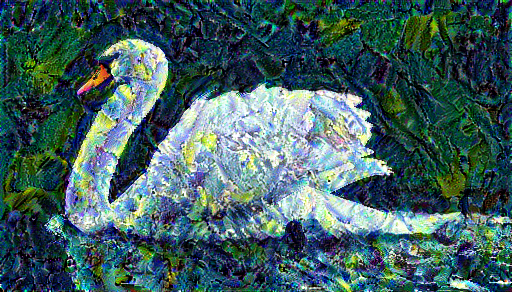

Train step: 600


In [ ]:
style_weight =  5e-2
content_weight = 1e-2 
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1.0, decay_steps=1000, decay_rate=0.80))
adam = tf.optimizers.Adam(10)
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, style_weight=style_weight, content_weight=content_weight, optimizer=adam, epochs=6, steps_per_epoch=100)

In [ ]:
GIF_PATH = PATH+prefix+' style_transfer.gif'
gif_images = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images]

gif_path = mimsave(GIF_PATH, gif_images,duration=0.1)


# with open(GIF_PATH,'rb') as f:
#   display_fn(Image(data=f.read(), format='png'))

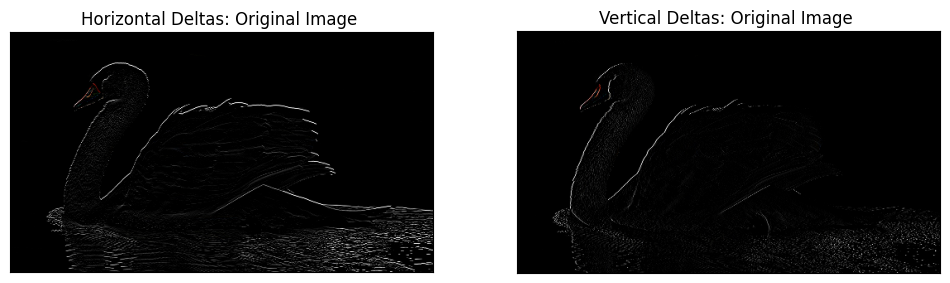

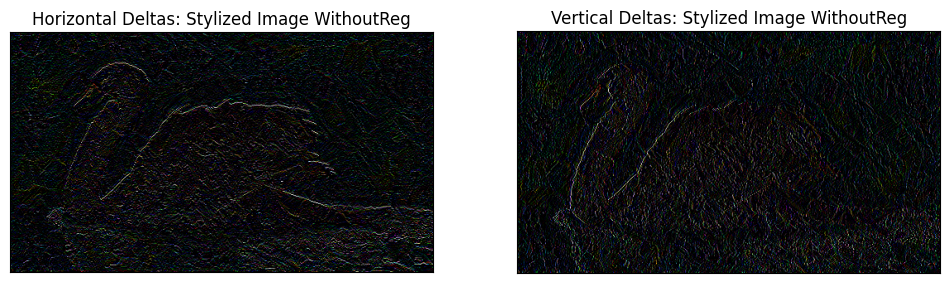

In [ ]:
original_x_deltas, original_y_deltas = high_pass_x_y(tf.image.convert_image_dtype(content_image, dtype=tf.float32))
stylized_image_x_deltas, stylized_image_y_deltas = high_pass_x_y(tf.image.convert_image_dtype(stylized_image, dtype=tf.float32))
plot_deltas((original_x_deltas, original_y_deltas), (stylized_image_x_deltas, stylized_image_y_deltas),loc="WithoutReg")

## WithReg


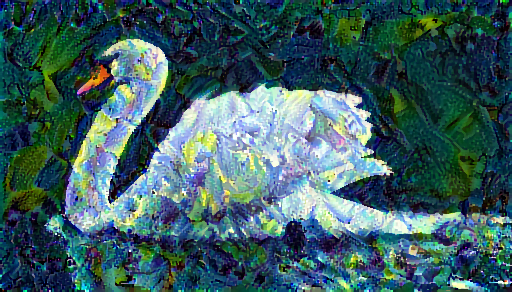

Train step: 600


In [ ]:
style_weight =  200e-2
content_weight = 1e-2
var_weight = 80

adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50))
adam = tf.optimizers.Adam(10)

stylized_image_reg, display_images_reg = fit_style_transfer(style_image=style_image, content_image=content_image, style_weight=style_weight, content_weight=content_weight,var_weight=var_weight, optimizer=adam, epochs=6, steps_per_epoch=100)

In [ ]:
GIF_PATH = PATH+prefix+' style_transfer_reg.gif'

gif_images_reg = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images_reg]
gif_path_reg = mimsave(GIF_PATH, gif_images_reg,duration=0.1)

# with open(GIF_PATH,'rb') as f:
#   display_fn(Image(data=f.read(), format='png'))

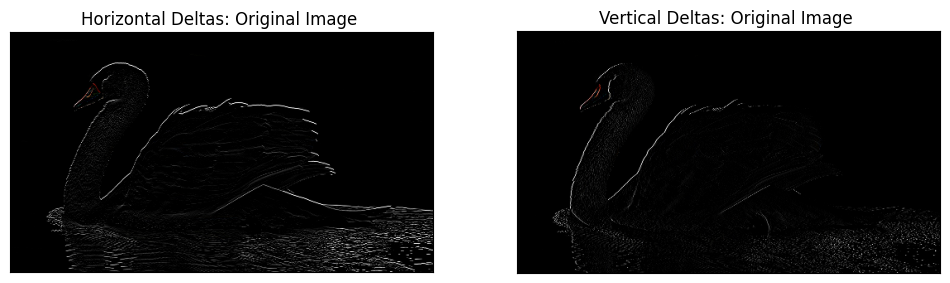

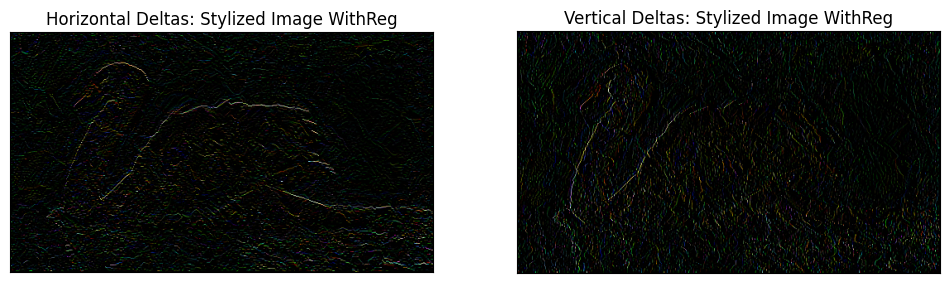

In [ ]:
original_x_deltas, original_y_deltas = high_pass_x_y(tf.image.convert_image_dtype(content_image, dtype=tf.float32))
stylized_image_reg_x_deltas, stylized_image_reg_y_deltas = high_pass_x_y(tf.image.convert_image_dtype(stylized_image_reg, dtype=tf.float32))
plot_deltas((original_x_deltas, original_y_deltas), (stylized_image_reg_x_deltas, stylized_image_reg_y_deltas),loc="WithReg")

## Output

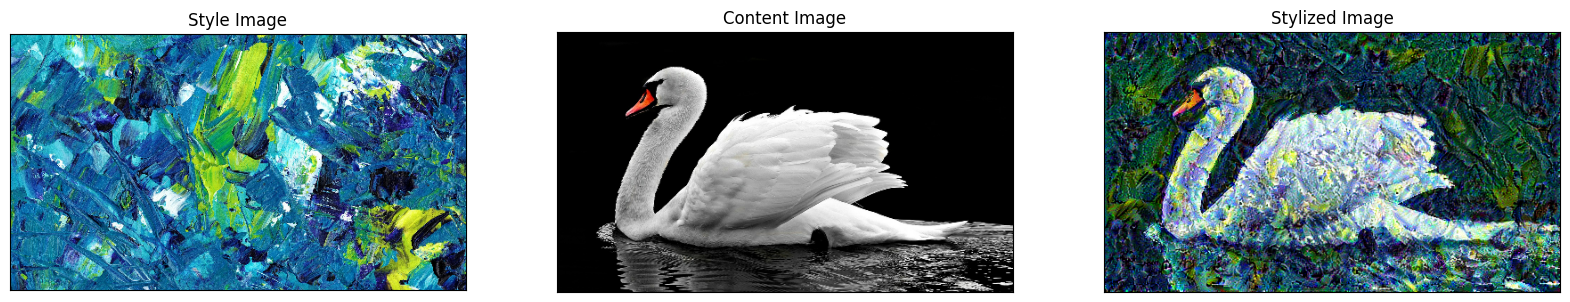

In [ ]:
show_images_with_objects([style_image, content_image, stylized_image], titles=['Style Image', 'Content Image', 'Stylized Image'])
plt.savefig(PATH+prefix+" OutputWithoutReg.jpg", bbox_inches='tight')

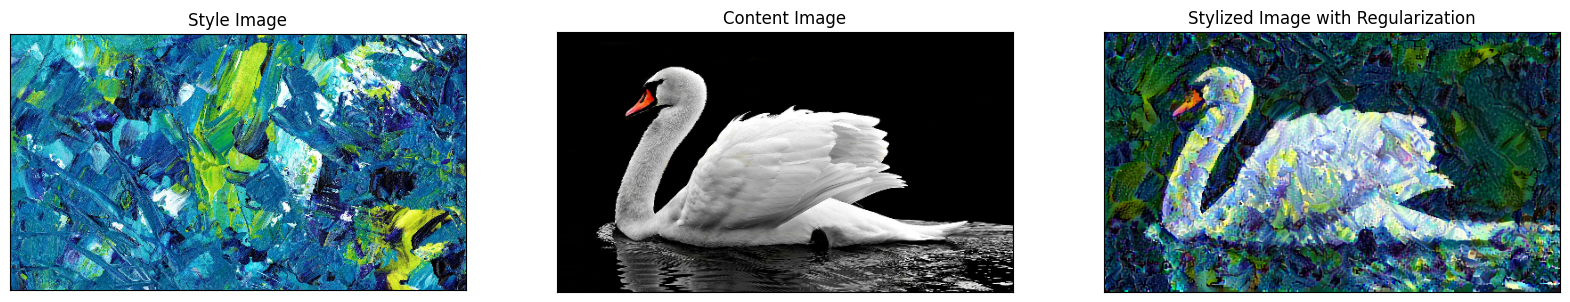

In [ ]:
show_images_with_objects([style_image, content_image, stylized_image_reg], titles=['Style Image', 'Content Image', 'Stylized Image with Regularization'])
plt.savefig(PATH+prefix+" OutputWithReg.jpg", bbox_inches='tight')

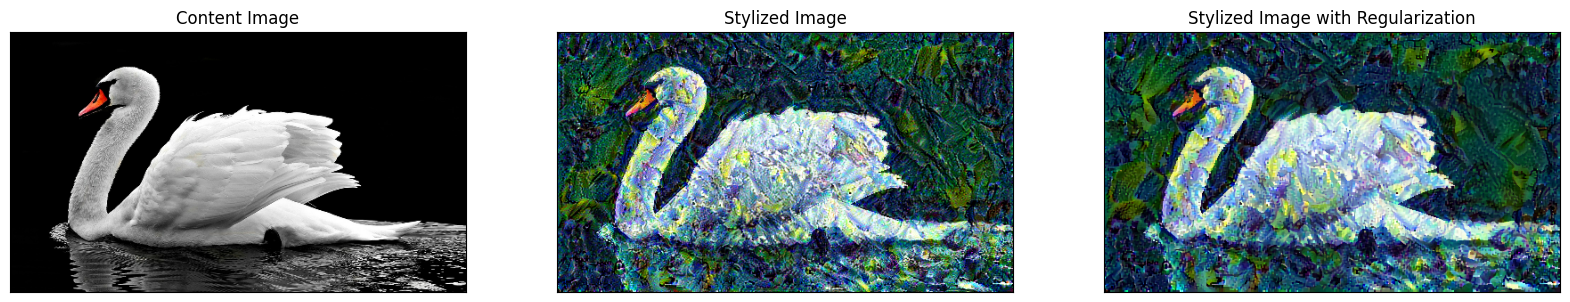

In [ ]:
show_images_with_objects([content_image,stylized_image ,stylized_image_reg], titles=['Content Image','Stylized Image' ,'Stylized Image with Regularization'])
plt.savefig(PATH+prefix+" OutputBoth.jpg", bbox_inches='tight')